##### Importando as bibliotecas e Preparando os dados


In [2]:
# Importando as bibliotecas
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns

# Bibliotecas para o modelo de rede neural convolucional
import tensorflow as tf

# Bibliotecas para avaliação do modelo
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

tf.get_logger().setLevel('ERROR')


In [3]:
# Declarando variáveis

# Caminho dos datasets
path = './chest_xray/'
normal_classe = 'NORMAL'
pneumonia_classe = 'PNEUMONIA'

# Treino
treinamento_folder = os.path.join(path, 'train/')
treinamento_normal_dir = os.path.join(treinamento_folder, normal_classe)
treinamento_pneumonia_dir = os.path.join(treinamento_folder, pneumonia_classe)

# Teste
teste_folder = os.path.join(path, 'test/')
teste_normal_dir = os.path.join(teste_folder, normal_classe)
teste_pneumonia_dir = os.path.join(teste_folder, pneumonia_classe)

# Validação
validacao_folder = os.path.join(path, 'val/')
validacao_normal_dir = os.path.join(validacao_folder, normal_classe)
validacao_pneumonia_dir = os.path.join(validacao_folder, pneumonia_classe)

# Tamanho das imagens
img_width = 196
img_height = 196

# Variáveis para o treinamento
batch_size = 32
epochs = 100

class_names = [normal_classe, pneumonia_classe]


In [4]:
# Checando se os nomes das classes são iguais
class_names = os.listdir(treinamento_folder)

if class_names == os.listdir(teste_folder) == os.listdir(validacao_folder):
    print("Nome das classes: %s" % (class_names))
else:
    raise Exception("Nome das classes não são iguais.")


Nome das classes: ['NORMAL', 'PNEUMONIA']


In [34]:
# Carregando os datasets

# Carregando o dataset de treinamento
dataset_treinamento = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Carregando o dataset de validação
dataset_validacao = tf.keras.preprocessing.image_dataset_from_directory(
    validacao_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Carregando o dataset de teste
dataset_teste = tf.keras.preprocessing.image_dataset_from_directory(
    teste_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)


Found 5216 files belonging to 2 classes.
Found 33 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


Text(0.5, 1.0, 'DADOS DE TESTE')

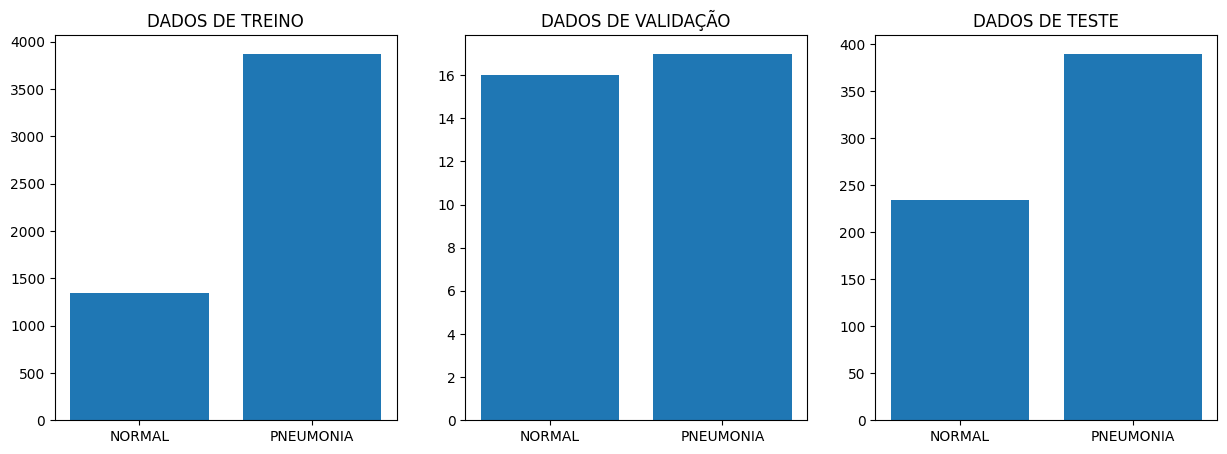

In [6]:
# Plotando graficos de barras com a quantidade de imagens de cada classe nos datasets
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(class_names, [len(os.listdir(treinamento_normal_dir)), len(
    os.listdir(treinamento_pneumonia_dir))])
plt.title('DADOS DE TREINO')

plt.subplot(1, 3, 2)
plt.bar(class_names, [len(os.listdir(validacao_normal_dir)),
        len(os.listdir(validacao_pneumonia_dir))])
plt.title('DADOS DE VALIDAÇÃO')

plt.subplot(1, 3, 3)
plt.bar(class_names, [len(os.listdir(teste_normal_dir)),
        len(os.listdir(teste_pneumonia_dir))])
plt.title('DADOS DE TESTE')


In [7]:
# Preparando os dados para o treinamento
def preprocess_image(image, label):
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)

    return image, label


dataset_treinamento = dataset_treinamento.map(preprocess_image)
dataset_validacao = dataset_validacao.map(preprocess_image)
dataset_teste = dataset_teste.map(preprocess_image)


##### Criação e treinamento do modelo


In [9]:
# Modelagem COM Transferência de Aprendizado
# Aqui vamos preparar o modelo de acordo com nossos requisitos

# Vamos preparar nossa camada de entrada para passar o tamanho da imagem. o padrão é (224,224,3). vamos alterá-lo para o tamanho da imagem que estamos usando.
input_layer = tf.keras.layers.Input(shape=(img_width, img_height, 3))

# Inicializando o modelo de transferência  com as propriedades apropriadas para nossas necessidades.
# Estamos passando parâmetros como:
# 1) weights='imagenet' - Usando isso, estamos carregando os pesos como os pesos originais.
# 2) input_tensor para passar o modelo usando input_tensor
# 3) Queremos alterar a última camada, então não estamos incluindo a camada superior

model_tl = tf.keras.applications.MobileNetV3Small(
    weights='imagenet', input_tensor=input_layer, include_top=False)

# Visualizando o sumário do modelo com nossas propriedades.
model_tl.summary()


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 196, 196, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 98, 98, 16)  64          ['Conv[0][0]']    

In [10]:
# Acessando a última camada do modelo e adicionando Flatten e Dense após ela

# Ultima camada do modelo
last_layer = model_tl.output

# Adicionando uma camada Flatten
flatten = tf.keras.layers.Flatten()(last_layer)

# Adicionando uma camada Dense para a camada de saída final
output_layer = tf.keras.layers.Dense(2, activation='softmax')(flatten)

# Criando o modelo com a camada de entrada e a camada de saída
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Sumário do modelo final com as camadas adicionadas
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 196, 196, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 98, 98, 16)  64          ['Conv[0][0]']               

In [11]:
# Congelando todas as camadas, exceto a última camada para impedir que o modelo de transferência do conhecimento seja treinado novamente

for layer in model.layers[:-1]:
    layer.trainable = False
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 196, 196, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 98, 98, 16)  64          ['Conv[0][0]']               

In [12]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
])

model = tf.keras.Sequential([
    data_augmentation,
    model
])


In [13]:
# Compilando o modelo

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [14]:
# Treinamento do modelo

# Monitora a perda de validação e interrompe o treinamento quando a perda
# de validação não melhora por 5 épocas consecutivas para evitar overfitting
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

history = model.fit(
    dataset_treinamento,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    validation_data=dataset_validacao,
    callbacks=[earlystopping]
)


Epoch 1/100
163/163 [==============================] - 33s 162ms/step - loss: 0.7274 - accuracy: 0.9262 - val_loss: 0.5518 - val_accuracy: 0.9091
Epoch 2/100
163/163 [==============================] - 29s 178ms/step - loss: 0.1736 - accuracy: 0.9663 - val_loss: 1.1965 - val_accuracy: 0.8788
Epoch 3/100
163/163 [==============================] - 28s 171ms/step - loss: 0.1693 - accuracy: 0.9705 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 4/100
163/163 [==============================] - 30s 180ms/step - loss: 0.1399 - accuracy: 0.9753 - val_loss: 0.0874 - val_accuracy: 0.9697
Epoch 5/100
163/163 [==============================] - 30s 180ms/step - loss: 0.1471 - accuracy: 0.9753 - val_loss: 2.8276 - val_accuracy: 0.7879
Epoch 6/100
163/163 [==============================] - 30s 183ms/step - loss: 0.1642 - accuracy: 0.9774 - val_loss: 0.1800 - val_accuracy: 0.9394
Epoch 7/100
163/163 [==============================] - 31s 185ms/step - loss: 0.1776 - accuracy: 0.9749 - val_loss: 0.2188 -

<Figure size 640x480 with 0 Axes>

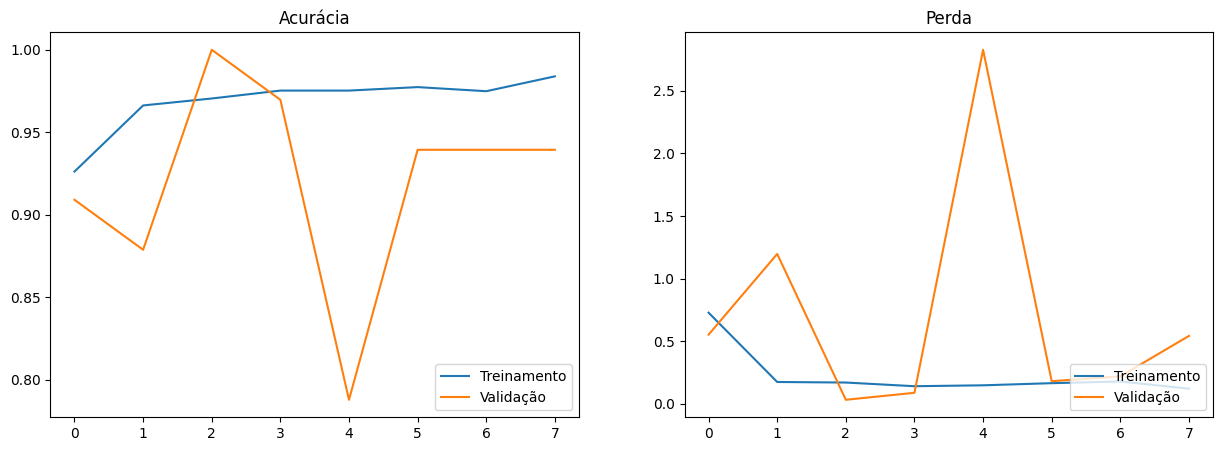

In [15]:
# Função para plotar gráficos de acurácia e loss do modelo
def plot_model(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.gcf().clear()
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('Acurácia')
    plt.plot(epochs_range, accuracy, label='Treinamento')
    plt.plot(epochs_range, val_accuracy, label='Validação')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Perda')
    plt.plot(epochs_range, loss, label='Treinamento')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.legend(loc='lower right')


plot_model(history)


##### Validação do modelo


In [26]:
# Função para plotar imagens e predições do modelo
def plot_results(dataset):

    features, labels = dataset.as_numpy_iterator().next()
    predictions = model.predict(features)

    num_rows = 4
    num_cols = 4
    total = num_rows*num_cols

    plt.gcf().clear()
    plt.figure(figsize=(2*num_cols, 2*num_rows))

    len = predictions.shape[0]

    arrayindex = random.sample(range(len), 25)

    for i in range(total):
        plt.subplot(num_rows, num_cols, i+1)
        index = arrayindex[i]

        predictions_array = predictions[index]
        true_label = np.argmax(labels, axis=1)[index]

        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.imshow(features[index].astype('uint8'), cmap=plt.cm.binary)

        predicted_label = np.argmax(predictions_array)

        if (predicted_label == true_label):
            color = 'green'
        else:
            color = 'red'

        percentage = 100*np.max(predictions_array)

        plt.xlabel("{} {:2.0f}% \n ({})".format(
            class_names[predicted_label], percentage, class_names[true_label]), color=color)

    plt.subplots_adjust(hspace=0.5)


1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

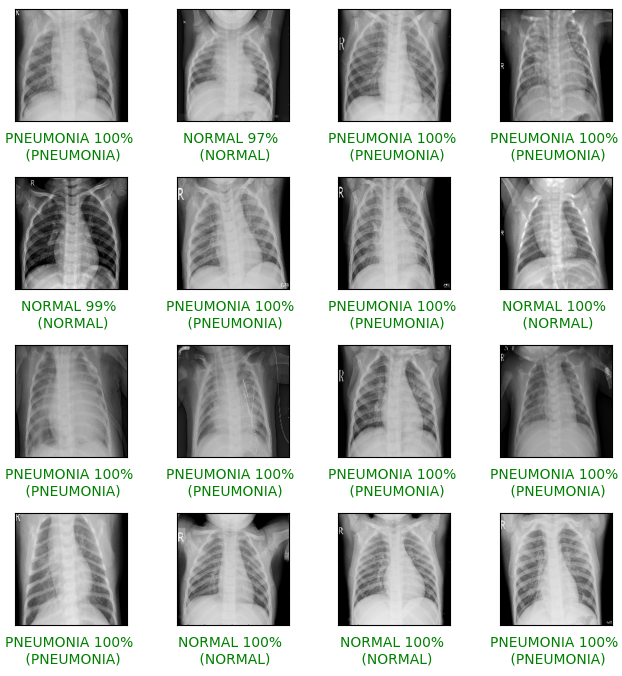

In [27]:
# Plotando os resultados do modelo no dataset de validacao

plot_results(dataset_validacao)


1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

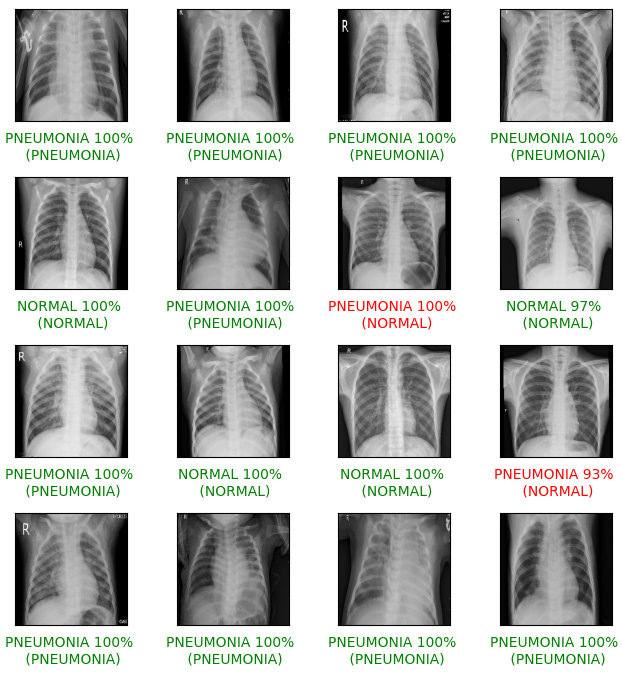

In [30]:
# Plotando os resultados do modelo no dataset de teste

plot_results(dataset_teste)

In [31]:
# Função para obter os resultados do modelo

def get_results(dataset):
    count = 0
    label_list = []
    prediction_list = []

    for features, labels in dataset:
        predictions = model.predict(features)
        for i in range(batch_size):
            label = np.argmax(labels[i])
            label_list.append(label)

            prediction_list.append(np.argmax(predictions[i]))
            count += 1

            if (i+1 == len(predictions)):
                break

    return label_list, prediction_list


val_labels, val_predictions = get_results(dataset_validacao)
test_labels, test_predictions = get_results(dataset_teste)


1/1 [==============================] - 0s 22ms/step


Porcentagem de acerto - Validação: 100%
Porcentagem de acerto - Teste: 84%


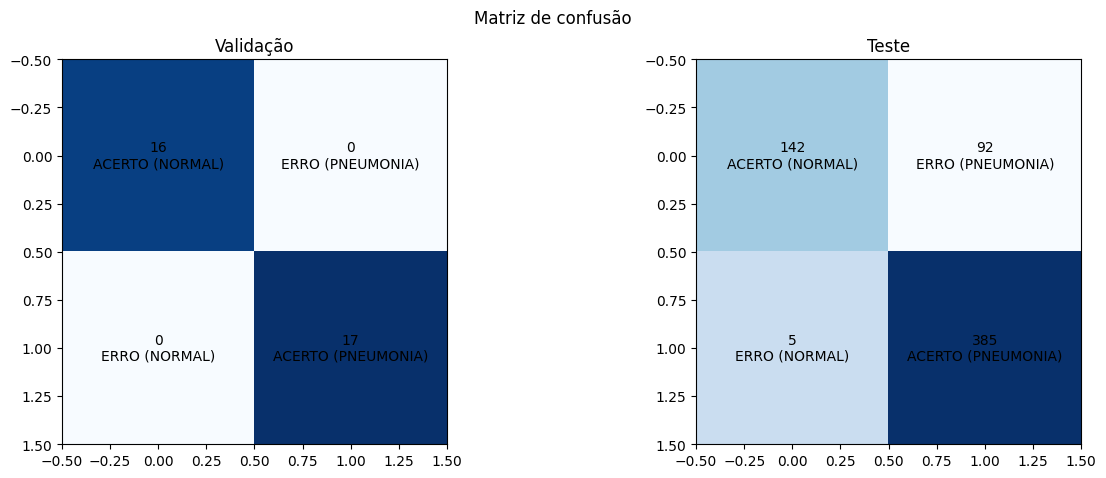

In [32]:
# Matriz de confusão

plt.figure(figsize=(15, 5))
plt.suptitle("Matriz de confusão")


def plot_confusion_matrix(predictions, labels, title='Confusion Matrix', i=1):
    plt.subplot(1, 2, i)

    # Matriz de confusão
    matrix = confusion_matrix(labels, predictions)

    porcentagem_acerto = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix) * 100

    print(f'Porcentagem de acerto - {title}: {round(porcentagem_acerto)}%')

    plt.imshow(matrix, cmap=plt.cm.Blues)

    # Adicionando os nomes das classes e os valores
    for i in range(2):
        for j in range(2):
            text = 'ACERTO' if i == j else 'ERRO'
            text_final = f'{matrix[i, j]}\n{text} ({class_names[i]})'
            plt.text(i, j, text_final, va='center', ha='center')

    plt.title(title)


plot_confusion_matrix(val_labels, val_predictions,
                      title='Validação', i=1)
plot_confusion_matrix(test_labels, test_predictions,
                      title='Teste', i=2)


(0.8865571385787019, 0.7970085470085471, 0.8167633890054401, None)

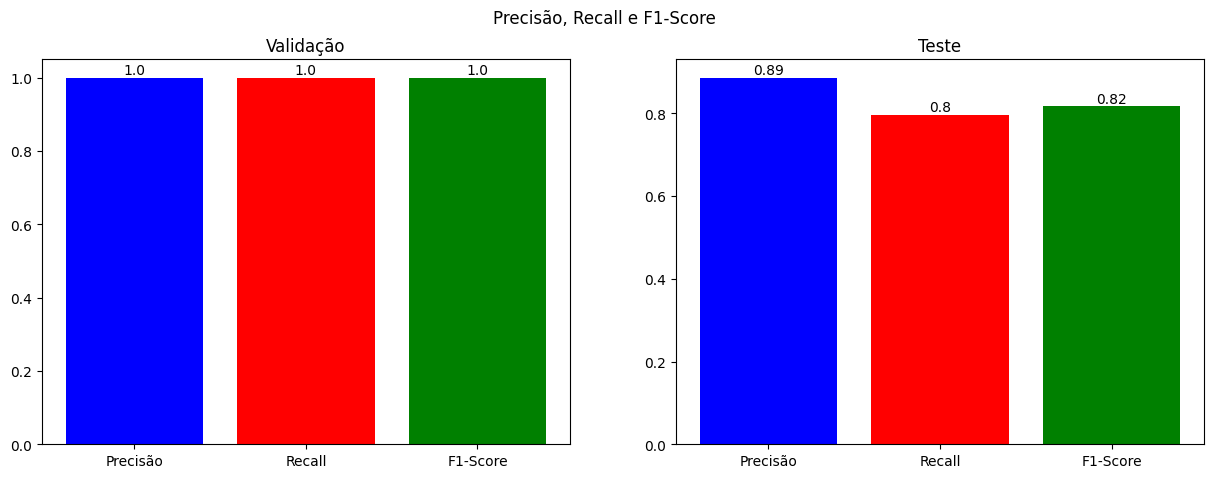

In [33]:
# Gráfico de precisão, recall e f1-score

plt.figure(figsize=(15, 5))
plt.suptitle("Precisão, Recall e F1-Score")


def plot_precision(predictions, labels, title='Precisão', i=1):
    precision = precision_recall_fscore_support(
        labels, predictions, average='macro')

    plt.subplot(1, 2, i)
    plt.bar(['Precisão'], precision[0], color='blue')
    plt.bar(['Recall'], precision[1], color='red')
    plt.bar(['F1-Score'], precision[2], color='green')

    # Exibindo os valores de precisão, recall e f1-score
    plt.text(0, precision[0], round(precision[0], 2), ha='center', va='bottom')
    plt.text(1, precision[1], round(precision[1], 2), ha='center', va='bottom')
    plt.text(2, precision[2], round(precision[2], 2), ha='center', va='bottom')
    plt.title(title)
    return precision


plot_precision(val_predictions, val_labels,
               title='Validação', i=1)
plot_precision(test_predictions, test_labels,
               title='Teste', i=2)
